In [1]:
import matplotlib
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
import numpy as np
from matplotlib.lines import Line2D
PLT_CELL = 5
FIG_DIR = "./"
DATA_PATH = "../../data/simulated/Synthetic_1000/dyn-BFStrange/dyn-BFStrange-1000-1/"
# DATA_PATH = "../../../sc-causal-grn/manuscript/data_simulation/data/archived/Synthetic_1000/dyn-BFStrange/dyn-BFStrange-1000-1/"

In [2]:
adata = ad.read_h5ad(DATA_PATH + "anndata.h5ad")

In [3]:
sc.tl.tsne(adata, perplexity = 250, random_state = 3)

Text(0, 0.5, 'tsne2')

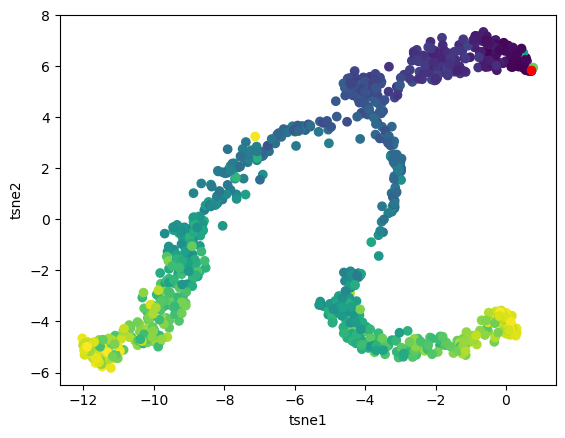

In [4]:
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = adata.obs.dpt)
plt.scatter(adata.obsm["X_tsne"][adata.uns['iroot'], 0], adata.obsm["X_tsne"][adata.uns['iroot'], 1], c = "red")
plt.xlabel("tsne1")
plt.ylabel("tsne2")

In [5]:
sc.tl.dpt(adata, n_branchings = 1)

Text(0.5, 0, 'tSNE2')

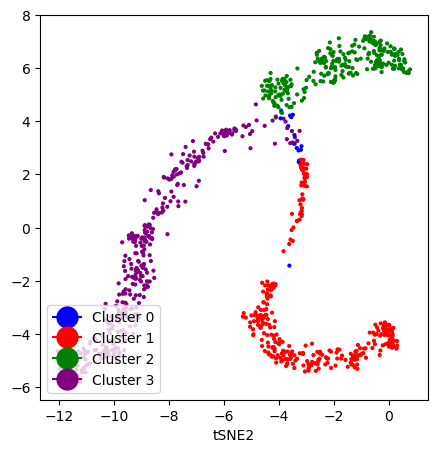

In [6]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
color_dict = {"0" : "blue", "1" : "red", "2" : "green", "3" : "purple"}
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = [color_dict[x] for x in adata.obs.dpt_groups], s = 4)
legend_elements = [Line2D([0], [0], marker='o', color=v, label='Cluster %s' % k, markerfacecolor=v, markersize=15)
                    for (k, v) in color_dict.items()]
plt.gca().legend(handles=legend_elements, loc='lower left')
plt.xlabel("tSNE1")
plt.xlabel("tSNE2")

In [7]:
# remap dpt groups for Synthetic_1000
# 1
dpt_group_map = {"0" : "0", 
                 "1" : "1", 
                 "2" : "0", 
                 "3" : "2"}
adata.obs.dpt_groups = adata.obs.dpt_groups.apply(lambda x : dpt_group_map[x])

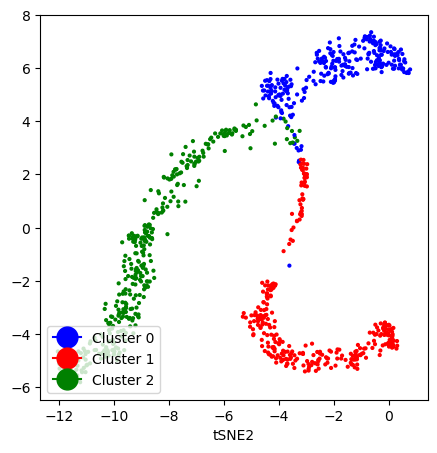

In [8]:
plt.figure(figsize = (PLT_CELL, PLT_CELL))
color_dict = {"0" : "blue", "1" : "red", "2" : "green", "3" : "purple"}
plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = [color_dict[x] for x in adata.obs.dpt_groups], s = 4)
legend_elements = [Line2D([0], [0], marker='o', color=v, label='Cluster %s' % k, markerfacecolor=v, markersize=15)
                    for (k, v) in color_dict.items()]
plt.gca().legend(handles=legend_elements[0:3], loc='lower left')
plt.xlabel("tSNE1")
plt.xlabel("tSNE2")
plt.savefig(FIG_DIR + "bifurc_sim_tsne.pdf")

In [9]:
np.save(DATA_PATH + "X_tsne2.npy", adata.obsm["X_tsne"])
np.save(DATA_PATH + "dpt_pseudotime.npy", adata.obs.dpt_pseudotime)
np.save(DATA_PATH + "clusterid.npy", np.array([int(x) for x in adata.obs.dpt_groups]))

In [10]:
adata.obsm["X_tsne"] = np.load(DATA_PATH + "X_tsne2.npy")

In [11]:
# NMF
import networkx as nx
import os
import sys
sys.path.append("../../scripts")
import visutil

try:
    my_purple = matplotlib.colors.LinearSegmentedColormap.from_list("MyPurple", ['purple', 'purple', ])
    matplotlib.colormaps.register(cmap = my_purple)
    my_red = matplotlib.colors.LinearSegmentedColormap.from_list("MyRed", ['red', 'red', ])
    matplotlib.colormaps.register(cmap = my_red)
    my_grey = matplotlib.colors.LinearSegmentedColormap.from_list("MyGrey", ['#595959', '#595959', ])
    matplotlib.colormaps.register(cmap = my_grey)
except:
    pass

U = np.load(DATA_PATH + "U.npy")
V = np.load(DATA_PATH + "V.npy")
V = np.swapaxes(V.reshape(adata.shape[1], adata.shape[1], -1), 0, 1).reshape(adata.shape[1]**2, -1) # fix Julia orientation

In [12]:
import pygam
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, u) for u in U.T]
U_gam = np.vstack([g.predict(adata.obs.dpt) for g in coeff_gam]).T
perm = np.argsort([np.dot(adata.obs.dpt, x / sum(x)) for x in U_gam.T])
U = U[:, perm]
U_gam = U_gam[:, perm]
V = V[:, perm]
del perm

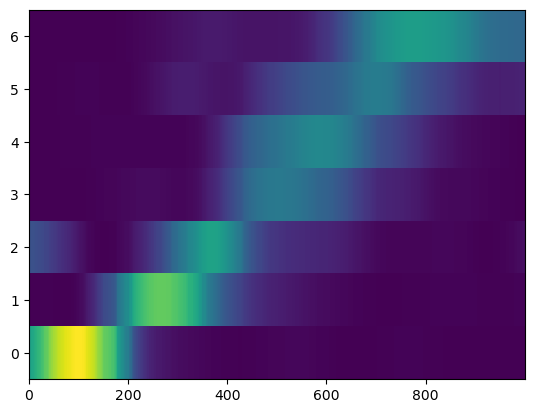

In [13]:
plt.imshow(U_gam[np.argsort(adata.obs.dpt), :].T, interpolation = "none", origin = "lower")
plt.axis("auto")
plt.savefig("NMF_vs_pseudotime.pdf")

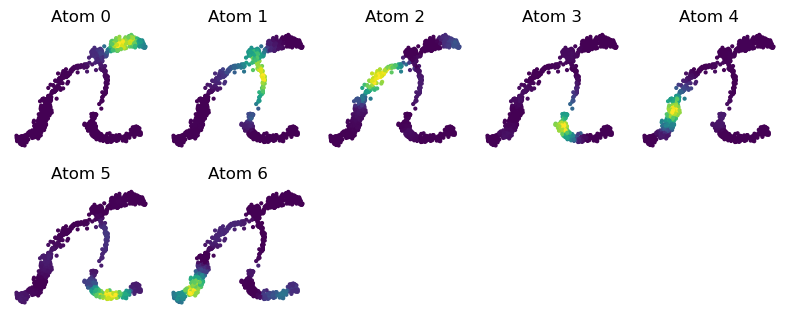

In [14]:
plt.figure(figsize = (8, 8))
for i in range(U.shape[1]):
    plt.subplot(5, 5, i+1)
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = U[:, i], s = 4, vmax = np.quantile(U[:, i], 0.99))
    plt.title("Atom {}".format(i))
    plt.axis("off")
plt.tight_layout()
plt.savefig("NMF_bifurcating_modules_activities.pdf")

In [15]:
import ot 
import itertools
from tqdm import tqdm
import pandas as pd

C = np.zeros((U.shape[1], U.shape[1]))
for (i, j) in tqdm(itertools.product(range(U.shape[1]), range(U.shape[1]))):
    if i > j:
        C[i, j] = ot.emd2(U[:, i] / U[:, i].sum(), U[:, j] / U[:, j].sum(), adata.obsm["C"])
        C[j, i] = C[i, j]

2023-10-31 16:41:32.497372: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-31 16:41:33.239173: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 16:41:34.452039: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-31 16:41:34.452584: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-31 16:41:36.345844: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [16]:
import importlib
importlib.reload(visutil)

<module 'visutil' from '/data/gpfs/projects/punim0638/stephenz/locaTE-paper/examples/simulated/../../scripts/visutil.py'>

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


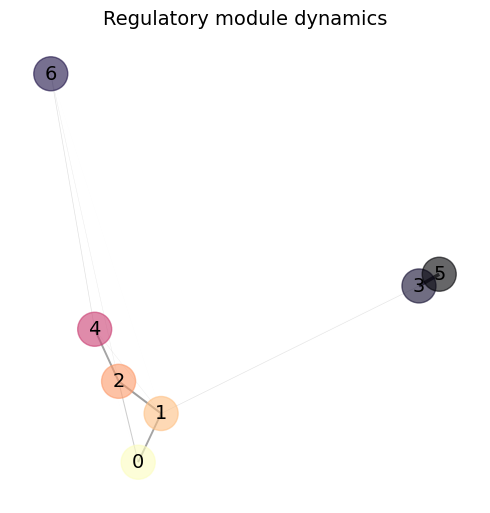

In [17]:
import sklearn as sk
from sklearn import neighbors
A = sk.neighbors.NearestNeighbors(n_neighbors=5, metric = 'precomputed').fit(C).kneighbors_graph(C).toarray()
A = 0.5*(A + A.T)
K = np.exp(-2.5*C / np.median(C)) * A
K /= K.max()
t = np.array([visutil.approx_hitting_time(K / K.sum(-1).reshape(-1, 1), 0, j) for j in range(K.shape[0])])
g = nx.Graph(K)

nx.set_node_attributes(g, {i : np.exp(-t[i] / t.max()) for i in range(len(t))}, "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
pos = nx.spectral_layout(g)
# pos = nx.spring_layout(g)
# discard self loops
g.remove_edges_from(nx.selfloop_edges(g))
plt.figure(figsize = (5, 5))
module_names = {i : str(i) for i in range(K.shape[0])}
visutil.draw(g, 
             gene_names = [str(module_names[i]) if i in module_names.keys() else "" for i in range(K.shape[0])], 
             thresh = 0.0, pos = pos, 
             kwargs_nodes = {"cmap" : plt.cm.magma, "alpha" : [0.6 if i in module_names.keys() else 0.3 for i in range(K.shape[0])], }, 
             kwargs_edges = {})
plt.tight_layout()
plt.axis("off")
plt.title("Regulatory module dynamics", fontsize = 14)
plt.savefig("NMF_bifurcating_modules.pdf")

In [18]:
import visutil

g_all = []
for k in module_names.keys():
    A = V[:, k]
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    g_all += [g, ]
thresh = 0.9
g_agg, nodes, pos = visutil.get_union_graph(g_all, adata.var.index, thresh, layout_args = "-Gstart=1")

pos = {0: (-0.3, 0), 
       1: (0.3, 0), 
       2: (0, -1),
       3: (-1, -1.5), 
       4: (1, -1.5),
       5: (-1/2, -2.25),
       6: (0, -1.75), 
       7: (0, -2.75), 
       8: (1/2, -2.25)}

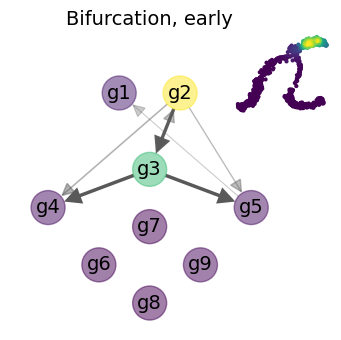

In [19]:
i = 0
A = V[:, i].reshape(adata.shape[1], adata.shape[1])
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (3.5, 3.5))
plt.margins(x = 0.125, y = 0.125)
# visutil.draw(g, adata.var.index, thresh = 0.995, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=0")
visutil.draw(g, adata.var.index, node_list = nodes, pos = pos, thresh = thresh, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
plt.gca().axis("off")
ax = plt.gca()
axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
axin.axis("off")
p = U[:, i]
axin.scatter(adata.obsm["X_tsne"][np.argsort(p), 0], adata.obsm["X_tsne"][np.argsort(p), 1], c = np.sort(p), s = 4)
axin.set_title("")
plt.title("Bifurcation, early", fontsize = 14)
plt.tight_layout()
plt.savefig("NMF_module_bifurc_early.pdf")

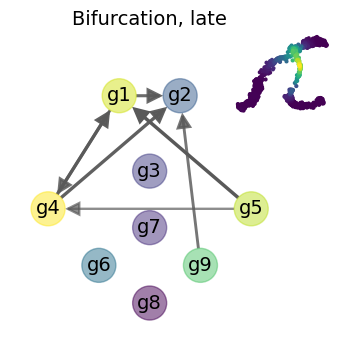

In [20]:
i = 1
A = V[:, i].reshape(adata.shape[1], adata.shape[1])
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (3.5, 3.5))
plt.margins(x = 0.125, y = 0.125)
# visutil.draw(g, adata.var.index, thresh = 0.995, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=0")
visutil.draw(g, adata.var.index, node_list = nodes, pos = pos, thresh = thresh, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
plt.gca().axis("off")
ax = plt.gca()
axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
axin.axis("off")
p = U[:, i]
axin.scatter(adata.obsm["X_tsne"][np.argsort(p), 0], adata.obsm["X_tsne"][np.argsort(p), 1], c = np.sort(p), s = 4)
axin.set_title("")
plt.title("Bifurcation, late", fontsize = 14)
plt.tight_layout()
plt.savefig("NMF_module_bifurc_late.pdf")

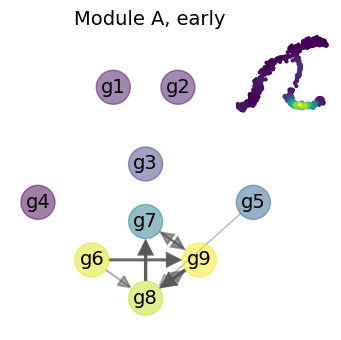

In [21]:
i = 5
A = V[:, i].reshape(adata.shape[1], adata.shape[1])
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (3.5, 3.5))
plt.margins(x = 0.125, y = 0.125)
# visutil.draw(g, adata.var.index, thresh = 0.995, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=0")
visutil.draw(g, adata.var.index, node_list = nodes, pos = pos, thresh = thresh, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
plt.gca().axis("off")
ax = plt.gca()
axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
axin.axis("off")
p = U[:, i]
axin.scatter(adata.obsm["X_tsne"][np.argsort(p), 0], adata.obsm["X_tsne"][np.argsort(p), 1], c = np.sort(p), s = 4)
axin.set_title("")
plt.title("Module A, early", fontsize = 14)
plt.tight_layout()
plt.savefig("NMF_module_A_early.pdf")

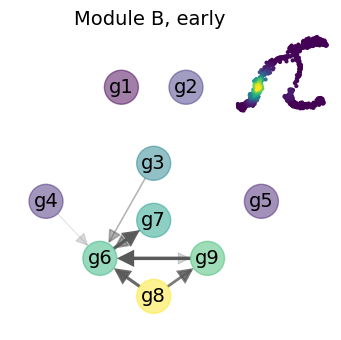

In [22]:
i = 4
A = V[:, i].reshape(adata.shape[1], adata.shape[1])
g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (3.5, 3.5))
plt.margins(x = 0.125, y = 0.125)
# visutil.draw(g, adata.var.index, thresh = 0.995, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"}, layout_args = "-Gstart=0")
visutil.draw(g, adata.var.index, node_list = nodes, pos = pos, thresh = thresh, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
plt.gca().axis("off")
ax = plt.gca()
axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
axin.axis("off")
p = U[:, i]
axin.scatter(adata.obsm["X_tsne"][np.argsort(p), 0], adata.obsm["X_tsne"][np.argsort(p), 1], c = np.sort(p), s = 4)
axin.set_title("")
plt.title("Module B, early", fontsize = 14)
plt.tight_layout()
plt.savefig("NMF_module_B_early.pdf")

In [23]:
# NTF
import seaborn as sb
# for i in range(3):
#     adata.uns["A_{}".format(i)] = np.load(DATA_PATH + "A_{}.npy".format(i+1))
# coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, u) for u in adata.uns["A_0"].T]
# U_gam = np.vstack([g.predict(adata.obs.dpt) for g in coeff_gam]).T
# perm = np.argsort([np.dot(adata.obs.dpt, x / sum(x)) for x in U_gam.T])
# adata.uns["A_0"] = adata.uns["A_0"][:, perm]
# adata.uns["A_1"] = adata.uns["A_1"][:, perm]
# adata.uns["A_2"] = adata.uns["A_2"][:, perm]
# U_gam = U_gam[:, perm]
# del perm
adata.uns["U_ntf"] = np.load(DATA_PATH + "U_ntf.npy")
adata.uns["V_ntf"] = np.load(DATA_PATH + "V_ntf.npy")
adata.uns["V_ntf"] = np.swapaxes(adata.uns["V_ntf"].reshape(adata.shape[1], adata.shape[1], -1), 0, 1).reshape(adata.shape[1]**2, -1) # fix Julia orientation
coeff_gam = [pygam.LinearGAM(pygam.s(0)).fit(adata.obs.dpt, u) for u in adata.uns["U_ntf"].T]
U_gam = np.vstack([g.predict(adata.obs.dpt) for g in coeff_gam]).T
perm = np.argsort([np.dot(adata.obs.dpt, x / sum(x)) for x in U_gam.T])
adata.uns["U_ntf"] = adata.uns["U_ntf"][:, perm]
adata.uns["V_ntf"] = adata.uns["V_ntf"][:, perm]
del perm

/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(455.5555555555555, 0.5, 'Regulatory module')

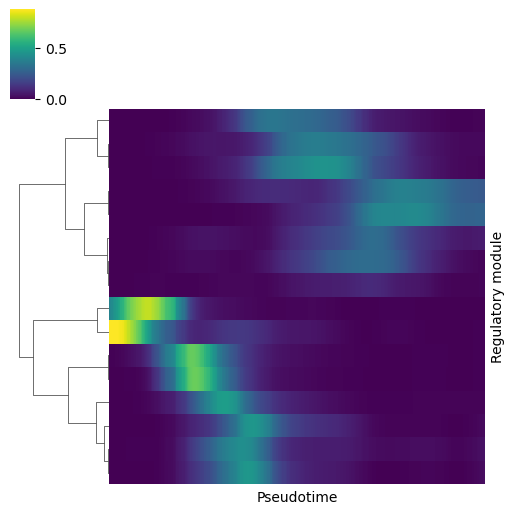

In [109]:
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis")
cg.ax_heatmap.set_xlabel("Pseudotime")
cg.ax_heatmap.set_ylabel("Regulatory module")

/tmp/ipykernel_49956/2986863881.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colordict = {i : matplotlib.cm.get_cmap('tab10')(i-1) for i in range(1, len(np.unique(clusterids))+1)}
/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(455.5555555555556, 0.5, 'Regulatory module')

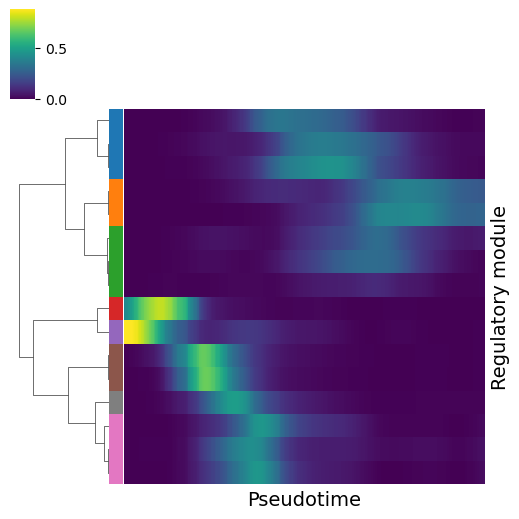

In [110]:
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import fcluster
Z = cg.dendrogram_row.calculated_linkage
clusterids = fcluster(Z, 8, criterion = 'maxclust')
colordict = {i : matplotlib.cm.get_cmap('tab10')(i-1) for i in range(1, len(np.unique(clusterids))+1)}
clusterdict = {k : "cluster_{}".format(k) for k in np.unique(clusterids)}
colors = [colordict[i] for i in clusterids]

from matplotlib.patches import Patch
cg = sb.clustermap(U_gam[np.argsort(adata.obs.dpt), :].T, row_cluster = True, col_cluster = False, metric = "correlation", xticklabels = False, yticklabels = False, figsize = (5, 5), cmap = "viridis", row_colors = colors, rasterized = True)
cg.ax_heatmap.set_xlabel("Pseudotime", fontsize = 14)
cg.ax_heatmap.set_ylabel("Regulatory module", fontsize = 14)

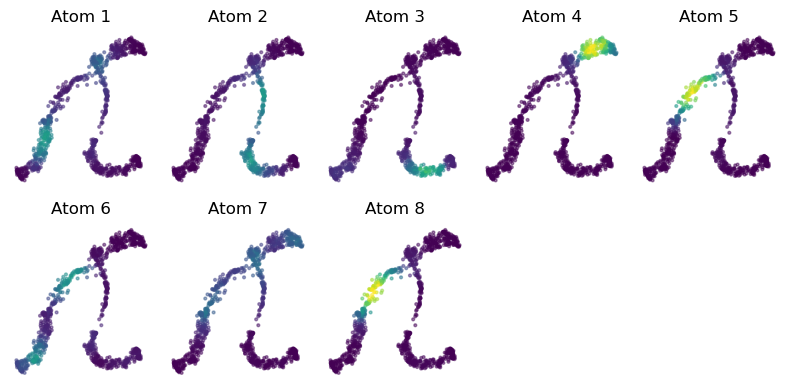

In [111]:
plt.figure(figsize = (8, 4))
for i in np.unique(clusterids):
    plt.subplot(2, 5, i)
    plt.scatter(adata.obsm["X_tsne"][:, 0], adata.obsm["X_tsne"][:, 1], c = adata.uns["U_ntf"][:, clusterids == i].mean(-1), s = 4, vmax = np.quantile(adata.uns["U_ntf"], 0.99), alpha = 0.5)
    plt.title("Atom {}".format(i))
    plt.axis("off")
plt.tight_layout()

In [112]:
import ot 
import itertools
from tqdm import tqdm
import pandas as pd

C = np.zeros((adata.uns["U_ntf"].shape[1], adata.uns["U_ntf"].shape[1]))
for (i, j) in tqdm(itertools.product(range(adata.uns["U_ntf"].shape[1]), range(adata.uns["U_ntf"].shape[1]))):
    if i > j:
        C[i, j] = ot.emd2(adata.uns["U_ntf"][:, i] / adata.uns["U_ntf"][:, i].sum(), adata.uns["U_ntf"][:, j] / adata.uns["U_ntf"][:, j].sum(), adata.obsm["C"])
        C[j, i] = C[i, j]

256it [00:25, 10.14it/s]


/data/gpfs/projects/punim0638/stephenz/miniconda3/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:433: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


Text(0.5, 1.0, 'Regulatory module dynamics')

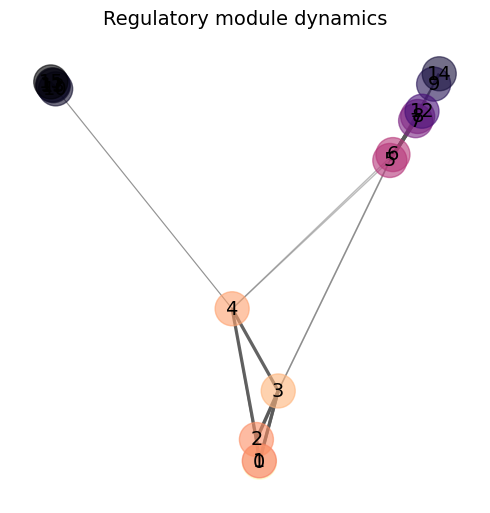

In [113]:
import sklearn as sk
from sklearn import neighbors
A = sk.neighbors.NearestNeighbors(n_neighbors=5, metric = 'precomputed').fit(C).kneighbors_graph(C).toarray()
A = 0.5*(A + A.T)
K = np.exp(-0.5*C / np.median(C)) * A
K /= K.max()
t = np.array([visutil.approx_hitting_time(K / K.sum(-1).reshape(-1, 1), 0, j) for j in range(K.shape[0])])
g = nx.Graph(K)

nx.set_node_attributes(g, {i : np.exp(-t[i] / t.max()) for i in range(len(t))}, "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
pos = nx.spectral_layout(g)
# pos = nx.spring_layout(g)
# discard self loops
g.remove_edges_from(nx.selfloop_edges(g))
plt.figure(figsize = (5, 5))
module_names = {i : str(i) for i in range(K.shape[0])}
visutil.draw(g, 
             gene_names = [str(module_names[i]) if i in module_names.keys() else "" for i in range(K.shape[0])], 
             thresh = 0.0, pos = pos, 
             kwargs_nodes = {"cmap" : plt.cm.magma, "alpha" : [0.6 if i in module_names.keys() else 0.3 for i in range(K.shape[0])], }, 
             kwargs_edges = {})
plt.tight_layout()
plt.axis("off")
plt.title("Regulatory module dynamics", fontsize = 14)

In [114]:
g_all = []
for k in range(adata.uns["U_ntf"].shape[1]):
    A = adata.uns["V_ntf"][:, k] # np.outer(adata.uns["A_1"][:, k].T, adata.uns["A_2"][:, k].T)
    g = nx.DiGraph(A.reshape(adata.shape[1], adata.shape[1]))
    g_all += [g, ]
thresh = 0.8
_, nodes, _ = visutil.get_union_graph(g_all, adata.var.index, thresh, layout_args = "-Gstart=1")

pos = {0: (-0.3, 0), 
       1: (0.3, 0), 
       2: (0, -1),
       3: (-1, -1.5), 
       4: (1, -1.5),
       5: (-1/2, -2.25),
       6: (0, -1.75), 
       7: (0, -2.75), 
       8: (1/2, -2.25)}

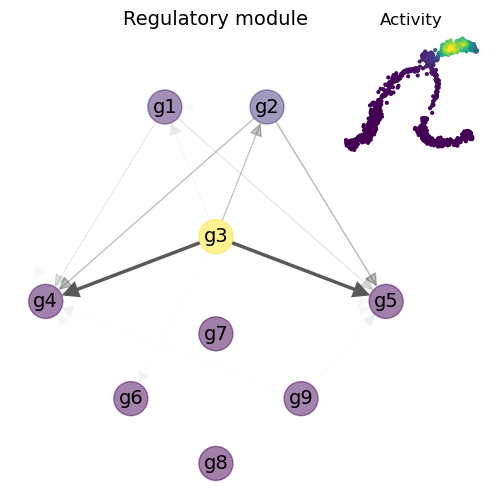

In [151]:
i = 0
A = adata.uns["V_ntf"][:, i].reshape(adata.shape[1], adata.shape[1]) # np.outer(adata.uns["A_1"][:, i].T, adata.uns["A_2"][:, i].T)
g = nx.DiGraph(A)
nx.set_node_attributes(g, nx.eigenvector_centrality(g.reverse(), weight = "weight", max_iter = 2_500), "centrality")
nx.set_edge_attributes(g, {(i, j) : 0 for (i, j) in g.edges}, name = "ref")
plt.figure(figsize = (5, 5))
# visutil.draw(g, adata.var.gene, thresh = 0.9975, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
visutil.draw(g, adata.var.index, node_list = nodes, pos = pos, thresh = thresh, cmap_dict = {0 : "MyGrey", 1 : "MyRed", -1 : "MyPurple"})
plt.gca().axis("off")
ax = plt.gca()
axin = ax.inset_axes([0.8, 0.8, 0.35, 0.3])
axin.axis("off")
p = adata.uns["U_ntf"][:, i]
axin.scatter(adata.obsm["X_tsne"][np.argsort(p), 0], adata.obsm["X_tsne"][np.argsort(p), 1], c = np.sort(p), s = 4)
axin.set_title("Activity")
plt.title("Regulatory module", fontsize = 14)
plt.tight_layout()